# [A continuous identity verification method based on free-text keystroke dynamics](http://ieeexplore.ieee.org.proxy1.lib.uwo.ca/document/7844242/authors)

In [1]:
import psycopg2
import pandas as pd
import sys
sys.path.append("..")
import credentials
import numpy as np
from datetime import datetime
import time
import string
from tqdm import tnrange, tqdm_notebook, tqdm
import numpy.ma as ma
from multiprocessing import Pool
from scipy.optimize import minimize
from BiokeyData import *
# This makes plots render inline

In [2]:
% matplotlib inline

In [3]:
key_codes = pd.read_csv('key_codes.csv').set_index('code').key.to_dict()

In [4]:
data = BiokeyData(credentials.postgres)

Loading Data
	- Attempting cache load
	- Loaded strokes from cache
Processing Data
	- Attempting cache load
	- Loaded dwell and flight from cache
Done Loading



In [5]:
def get_sequence(user_id=None, limit=None, filter_alpha=False):
    dwells = data.get_dwells(user_id).head(limit)
    dwells['key'] = dwells.key_code.apply(lambda x: key_codes[x] if x in key_codes else None)
    if filter_alpha:
        alpha = list(string.ascii_uppercase)
        dwells = dwells.loc[dwells.key.isin(alpha)]
    return dwells.reset_index(drop=True).sort_values('down')

# Finding Optimal Thresholds

In [6]:
def get_average_instances(df, t):
    chain = ''
    seqs = []
    for row in df.itertuples():
        chain = chain + row.key
        if row.interval > t:
            if len(chain) > 1:
                seqs.append(chain)
            chain = ''
    return np.unique(seqs, return_counts=True)[1].mean()

In [7]:
def optimize_user(user_id, limit, test_range):
    df = get_sequence(user_id=user_id, limit=limit, filter_alpha=True)
    S = df.key
    Interval = (df.shift(-1).down - df.down)
    orderedInterval = Interval.sort_values().reset_index(drop=True)
    df['interval'] = Interval
    # Build rough table for graph and optimization seed
    test_vals = pd.Series(test_range, index=test_range).apply(lambda x: get_average_instances(df, x))
    # Use optimization to find max (inverted min)
    res = minimize((lambda x: 1/get_average_instances(df, x)), test_vals.idxmax(), method='nelder-mead',options={'xtol': 1e-8})
    return {
        'test_vals': test_vals,
        'optimal': res.x[0]
    }

## Optimize a Single User

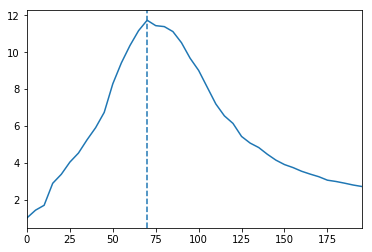

In [8]:
test_range = [x for x in range(0, 200, 5)]
res = optimize_user('5aa5405e-4574-4dc1-be50-b31e5bafc4cb', limit=100000, test_range=test_range)
res['test_vals'].plot().axvline(x=res['optimal'], linestyle='--')

## Optimize All Users

In [9]:
test_range = [x for x in range(0, 200, 5)]
test_vals = {}
optimals = {}
users_by_count = data.get_dwells().user_id.value_counts().index
for i in tnrange(len(users_by_count)):
    user = users_by_count[i]
    res =  optimize_user(user, limit=None, test_range=test_range)
    test_vals[user] = res['test_vals']
    optimals[user] = res['optimal']

Widget Javascript not detected.  It may not be installed or enabled properly.


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.


/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


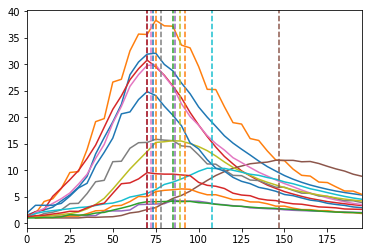

In [28]:
plt = pd.DataFrame(test_vals).plot()
for o in optimals:
    c = next(x._color for x in plt.legend().legendHandles if x._label == o)
    plt.axvline(x=optimals[o], color=c, linestyle='--')
plt.legend_.remove()

# Building Profile Using Threshold

In [11]:
def get_sequence_durations(df, t):
    S = df.key
    Interval = (df.shift(-1).down - df.down)
    orderedInterval = Interval.sort_values().reset_index(drop=True)
    df['interval'] = Interval
    chain = ''
    start = -1
    seqs = []
    for row in df.itertuples():
        if start == -1:
            start = row.down
        chain = chain + row.key
        if row.interval > t:
            if len(chain) > 1:
                seqs.append({'seq': chain, 'duration': row.up - start})
            chain = ''
            start = -1
    return pd.DataFrame(seqs)

def build_profile(df, t):
    seqs = get_sequence_durations(df, t)
    seq_dur = seqs.groupby('seq').aggregate(['mean', 'std', 'count']).duration
    est_std = (seq_dur['std']/seq_dur['mean']).mean()*seq_dur['mean']
    seq_dur['std'] = seq_dur['std'].fillna(est_std)
    return seq_dur

In [12]:
def get_distance(seq, seq_attr):
    seq_attr = seq_attr.loc[seq.seq]
    avg = seq_attr['mean']
    std = seq_attr['std']
    duration = seq.duration
    return np.exp(-np.square((-avg))/(2*np.square(std)))

def test_sequence(df, profile, t):
    seqs = get_sequence_durations(df.copy(), t)
    if 'seq' not in seqs:
        return 0
    seqs = seqs.loc[seqs.seq.isin(profile.index)]
    return seqs.apply((lambda x: get_distance(x, profile)), axis=1)

def test_sequence_window(df, profile, t):
    return test_sequence(df, profile, t).mean()

In [13]:
data.get_dwells().user_id.value_counts().index

Index(['5aa5405e-4574-4dc1-be50-b31e5bafc4cb',
       '1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f',
       '28513a33-02a3-4b09-88f6-92c9fdb9dcdf',
       'e85b3844-5af0-47ea-bf51-62da4b4efc39',
       '72cc4371-4288-4c84-b163-e441a55ea1bf',
       '7bb179ed-9f9f-46ce-a403-57e88a92f216',
       '91147071-c19d-485f-993e-d1cd2dc889cd',
       'ffbe1c9c-8dab-4ca2-8613-69e0bbc22cc9',
       '6708d19e-6765-4f96-99eb-d94b342aa665',
       'df2d03db-469c-4269-bf41-e320ac4c42ad',
       '62042708-5989-4bbf-a106-d7a66281b367',
       'f212c9bc-824a-4011-9a70-55a7d2f86ba2',
       'fbd73057-951a-406d-8c5a-67f551ad0e80',
       '3b57c0d9-2b14-4ec2-8b29-ad4e94811962'],
      dtype='object')

In [14]:
df = get_sequence(user_id='5aa5405e-4574-4dc1-be50-b31e5bafc4cb', limit=None, filter_alpha=True)
df2 = get_sequence(user_id='1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f', limit=None, filter_alpha=True)

In [15]:
profile = build_profile(df, 70)

In [16]:
seqs = test_sequence(df.copy(), profile, 70)
seqs2 = test_sequence(df2.copy(), profile, 70)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


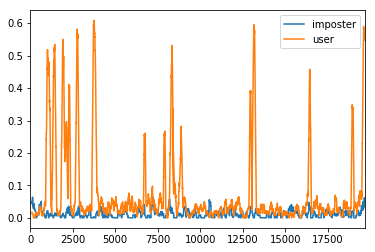

In [40]:
pd.DataFrame({'user': seqs, 'imposter': seqs2}).dropna().rolling(100).mean().plot()

In [42]:
pd.DataFrame({'user': seqs, 'imposter': seqs2}).to_csv('rolling_scores_test.csv')

In [37]:
window_size = 100
thresh = 70
scores = []
# length = df.key_code.count()+1
length = 100000
offset = 200000
indix = []
for  i in tnrange(window_size+offset, length+offset):
    indix.append((i-window_size,i))
    scores.append(test_sequence(df.loc[i-window_size:i], profile, thresh))
pd.Series(scores).plot()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


KeyError: 260057

59954/|/ 60%|| 59954/99900 [07:30<05:00, 133.10it/s]